In [167]:
%matplotlib inline
%pylab
from scipy.constants import m_e, epsilon_0, pi, e, mu_0

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


C:\Users\JH218595\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['e', 'pi']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Ohmic Heating
What is the maximum plasma temperature achievable with only the Ohmic heating ?

We will assume steady-state power balance, assuming Ohmic heating is balancing thermal losses:
$$
P_\Omega = \frac{W}{\tau_e}
$$

## 0D Analysis

Here we will assume that the main dimensions of the machine have been fixed to:

- $a$ = 2 m
- $\varepsilon$ = 0.4
- $\kappa$ = 2
- $B$ = 4.7 T
- $n_{20}$ = 1.5 [$\times 10^{20}$ $m^{-3}$]
- $q_\star$ = 2
- $A$ = 2.5

The plasma thermal losses are
$$
P_t = \frac{W}{\tau_e}
$$
where palsma energy is:
$$
    W = 3 n T V
$$
and the confinement time, for L-mode (relevant mode here) is :
$$
\tau_L
=
0.048  I^{0.85} R^{1.2} \kappa^{0.5} \hat n^{0.1} B^{0.2} A^{0.5} P^{0.5}  
$$
which can be reexpressed as:
$$
\tau_L
=
    0.037  
    \frac{\varepsilon^{0.3}}{q_\star^{1.7}}
    \frac{a^{1.7} \kappa^{1.7} \hat B^{2.1} A}{n_{20}^{0.8} T_k}  
$$


The Ohmic heating is:
$$
    P_\Omega
    =
    \int \eta J_\parallel^2 dr
$$
where $\eta_\parallel$ is the classical (parallel) [Spitzer resistivity](https://en.wikipedia.org/wiki/Spitzer_resistivity): [Freidberg Eq.(11.15)]
$$
\eta_\parallel
=
0.51 \frac{\sqrt{2} e^2 m_e^{1/2} }{12 \pi^{3/2} \varepsilon_0^2 T_e^{3/2}} \ln \Lambda
\approx
3.3 \times 10^{-8} / \hat T^{3/2}  \, \mathrm{\Omega.m}
$$

So
$$
    P_\Omega
    =
    3.3 \times 10^{-8} \frac{ I_p^2 }{ \hat T^{3/2} } V
$$

In [66]:
def q_star(I, a=2, kappa=2, epsilon=0.4, B=4.7):
    q = 2*pi*(a)**2 * kappa * B / (mu_0 * (a/epsilon) * I)
    return q

In [69]:
def tau_L(T_keV, I=15e6, a=2, B=4.7, n_20=1.5, epsilon=0.4, kappa=2, A=2.5):
    q_s = q_star(I, a, kappa, epsilon, B)
    tau = 0.037*epsilon**(0.3) * a**(1.7) * kappa**(1.7) * B**(2.1) * A / q_s**(1.7) / n_20**(0.8) / T_keV
    return tau

In [70]:
def P_th(T_keV, I=15e6, a=2, B=4.7, n_20=1.5, epsilon=0.4, kappa=2, q_star=2, A=2.5):   
    tau = tau_L(T_keV, I=I, a=a, B=B, n_20=n_20, epsilon=epsilon, kappa=kappa,A=A)
    P = 3*1e20*n_20 * 1e3*e*T_keV / tau
    return P

In [28]:
def resistivity(T_keV):
    LnLambda = 20  # approx
    return 0.51 * sqrt(2) * e**2 * m_e**(1/2) / (12 * pi**(3/2) * epsilon_0**2) * LnLambda / (e*1e3)**(3/2) / T_keV**(3/2)


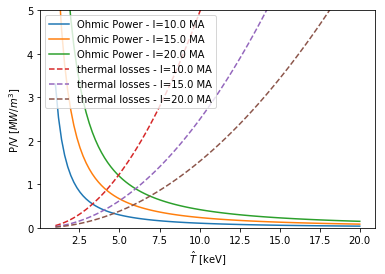

In [80]:
n = 15e19 # m^-3
T = linspace(1, 20, num=100) # keV
Is = [10e6, 15e6, 20e6]

fig, ax = subplots()
[ax.plot(T, 3.3*1e-8 * I**2 / T**(3/2)/1e6, label=f'Ohmic Power - I={I/1e6} MA') for I in Is]
[ax.plot(T, P_th(T, I)/1e6, ls='--', label=f'thermal losses - I={I/1e6} MA') for I in Is]

ax.set_ylabel('P/V [$MW/m^3$]')
ax.set_xlabel('$\hat T$ [keV]')
ax.set_ylim(0, 5)
ax.legend()


The conclusion for this 0D analysis is that for typical parameters of fusion reactor, the ohmic power is not enough to reach temperature high enough so that alpha heating becomes dominant (>7 keV). Thus the need of additional external heating systems. 

A different scaling law could have been choosen, for instance the Alcator scaling law:
$$
\tau_e = \frac{n_{20}}{2} a^2
$$

## 1D profiles
The Ohmic heating power density is:
$$
    S_\Omega (r)
    = \eta(r) j^2(r)
$$
in which both the plasma resistivity and current density depends on the geometry. The classical resistivity $\eta^{CL}$ (Spitzer) is independant of the geometry, however neo-classical resistivity $\eta^{NC}$ has a strong aspect ratio dependance:
$$
    \eta^{NC} (r) 
    =
    \frac{ \eta^{CL} }{\left( 1 - \left( \frac{r}{R} \right)^{1/2}  \right)^2}
$$
Approximating the later expression for $R/a=3$, one has:
$$
    \eta 
    \approx
    8\times 10^{-8} Z_{eff} \hat T^{-3/2}
$$
with $\hat T$ in keV.

Assuming the current profile if of the form
$$
    j(r) = j_0 \left( 1 - \frac{r^2}{a^2} \right)^\nu
$$

Then the averaged current density is 
$$
    \left< j^2 \right>
    =
    \frac{2}{a^2} \int_0^a j^2(r) r dr
    =
    \frac{j_0^2}{2\nu + 1}
$$

In [85]:
import sympy as sp
sp.init_printing()

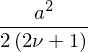

In [107]:
r = sp.symbols('r', real=True)
a, nu = sp.symbols('a nu', positive=True)

sp.simplify(sp.integrate( (1 - r**2 / a**2)**(2*nu)*r, (r,0,a) ))

The peak current density $j_0$ can be evaluated from Maxwell-Ampère at $r$:

$$
\oint B \cdot dl = \mu_0 \iint_\Sigma J \cdot dS
$$
leading to:
$$
2\pi r B_\theta(r) = 2\pi\mu_0  \int_0^r j(r') r' dr' 
$$

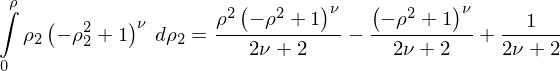

In [158]:
rho, rho2 = sp.symbols('rho rho2', real=True)
expr = sp.Integral( (1 - rho2**2)**nu * rho2, (rho2,0,rho))
sp.Eq(expr, expr.doit())

Which simplify further to:

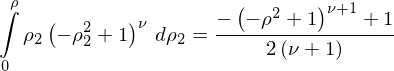

In [159]:
sp.Eq(expr, sp.simplify(sp.collect(sp.simplify(_.rhs),  (1-rho**2)**nu)))

So,
$$
B_\theta(r) = \frac{j_0 a^2 \mu_0}{r}  \frac{ 1 - \left(1-\frac{r^2}{a^2} \right)^{\nu+1} }{2(\nu + 1)}
$$

Using the safety safety factor definition:

The safety factor $q$, 
$$
q(r) = \frac{B(r) }{B_\theta(r)}  \frac{r}{R} 
$$
can be expressed as:
$$
q(r) = \frac{2(\nu + 1)}{j_0 a^2 \mu_0} \frac{B(r) }{R}  \frac{ r^2}{ 1 - (1-\frac{r^2}{a^2})^{\nu+1} }   
$$


Using the following limits:

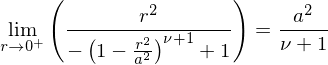

In [165]:
sp.Eq(
    sp.Limit(r**2/(1-(1-r**2/a**2)**(nu+1)), r,0),
    sp.limit(r**2/(1-(1-r**2/a**2)**(nu+1)), r,0))

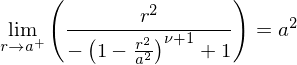

In [166]:
sp.Eq(
    sp.Limit(r**2/(1-(1-r**2/a**2)**(nu+1)), r,a),
    sp.limit(r**2/(1-(1-r**2/a**2)**(nu+1)), r,a))

One can define:
$$
    q_0 
    \doteq 
    \frac{2}{j_0  \mu_0} \frac{B_0 }{R}  
    $$

And 
$$
    q_a 
    \doteq
    \frac{2(\nu + 1)}{j_0 \mu_0} \frac{B(a) }{R}
    = (\nu + 1 ) q_0 \frac{B(a) }{B_0}
$$

One has for $r=0$:
$$
j_0 = \frac{2}{  \mu_0} \frac{B(r) }{q(r)}  \frac{1}{R}   
$$
which can be used for definition of $j_0$, for example in $\left< j^2 \right>$:
$$
    \left< j^2 \right>
    =
    \left( \frac{2}{\mu_0} \frac{B(r) }{R q(r)}  \right)^2 \frac{1}{2\nu + 1}
$$

$$
j_0 = \frac{2(\nu + 1)}{ a^2 \mu_0} \frac{r}{1 - (1)^{\nu+1} } \frac{B(r) }{q(r)}  \frac{r}{R}   
$$

which has particular values for $r=0$ and $r=a$:
$$
\frac{B(r) }{q(r)}  \frac{r}{R}  = \frac{j_0 a^2 \mu_0}{r}  \frac{ 1 - (1-\frac{r^2}{a^2})^{\nu+1} }{2(\nu + 1)}
$$

$$
q(0) = 
$$



$$
    P_\Omega
    =
    \eta 
    \left< J_\parallel^2 \right>
$$